# Step 1 Establishing route and libraries

In [148]:
# Importing libraries and dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #usado en el paso 3
import plotly_express as px
df = pd.read_csv("datasets/games.csv")


# Step 2 Data Processing (Data cleaning, correction and formatting)

In [149]:
# Setting columns to lowercase
df.columns = [column.lower() for column in df.columns]


In [150]:
#Look for duplicates, incorrect dtypes and nulls.
df.info()
print("_____________________")
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
_____________________


Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

 Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating have missing values.

In [151]:
# I proceed removing duplicated rows.
df.duplicated().sum() 

0

Not duplicated rows found

In [152]:
# Identifying null values
df.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [153]:
df[df["name"].isnull()]
df[df["year_of_release"].isnull()]
df[df["genre"].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


- name column = There are 2 missing games, I'll proceed to delete both rows (not enough or relevant information to keep).
- year_of_release column = It's possible to look at the internet for the name of the game, the platform and get the year_of_release, I'll keep it for the moment. (I can look for an API)
- genre = Same missing values as name column, I'll delete it
- critic_score, user_score, rating = Can keep it like this because I don't have the source where they get the data.

In [154]:
# Checking before transforming to float
df["user_score"].unique()
df["user_score"] = pd.to_numeric(df["user_score"],errors="coerce")
#df["user_score"].replace(np.nan,-999, inplace=True) #If it is necessary
df["user_score"]= df["user_score"].astype(float)


I decided to keep as an object for the moment

In [155]:
# Checking before transforming to float
df["critic_score"].unique()
# df["critic_score"].replace(np.nan,-999, inplace=True) #If it is necessary
df["critic_score"]= df["critic_score"].astype(float)

In [156]:
df["critic_score"].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

In [157]:
df["rating"].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

As I can see in the DataFrame info, more than the half of values are missing for the columns critic_score, user_score and rating, however I'll decide to not modified because I don't know the main source of this data, otherwise I could use an API to get it.

In the other hand I can look for the missing years for the specified games, I'll use IGDB database

'''As an extra effort, I connected to the IGDB API (https://www.igdb.com/api) to get the missing years. 
It was necessary to extract the missing values from this list to use it as parameters (game_name and platform)
'''

In [158]:

games_missing_year_df = df[df["year_of_release"].isna()]
filtered_df = games_missing_year_df[["name","platform"]]

#I manually created this relation table to create a search parameter in the IGDB site.
filtered_df["platform"].unique() #getting the missing paltforms
relation_df = pd.read_csv("datasets/platform_relation.csv") 
fusion = pd.merge(left= filtered_df, right= relation_df, on="platform", how="left")


The dataframe will be exported into a csv file to create a function which will search all the games by platform


In [159]:

def export_to_csv(dataframe):
    '''Save DataFrame in a csv file using with'''
    with open("./datasets/filtered_games_db.csv", 'a', encoding="utf-8", newline="") as f:
        # f.tell() specifies if the file has been executed before
        empty = f.tell() == 0
        # If new, use the headers
        if empty:
            fusion.to_csv(f, index=False, header=True,)
        else:
            # If not, ignore the headers
            fusion.to_csv(f, index=False, header=False)

export_to_csv(fusion)

In case you are interesed to see my script to get the API data, you can clone this repository "https://github.com/Carnivurus/project_6_ice_game_store.git"

In [160]:
#This is the info requested and received by the API
processed_df = pd.read_csv("datasets/processed_game_list.csv")

#35 Cases where not identified by the API I did a manual research and save the file into a csv
manually_fill_df = pd.read_csv("datasets/games_not_found.csv")

#Homologating db to concat with the processed_df
manually_fill_df.rename(columns={"game name":"db_name"},inplace=True)
manually_fill_df

processed_df = pd.concat([processed_df, manually_fill_df], ignore_index=True)

In [161]:
#Mergin the dabase with the API_database
merged_df = pd.merge(games_missing_year_df, processed_df, left_on=["name","platform"], right_on=["db_name","platform"], how="left")
merged_df["year_of_release"] = merged_df["year"]
d_columns = ["release_date", "game_name", "db_name", "year"]
merged_df.drop(columns=d_columns, inplace=True)
merged_df.head()
# merged_df[merged_df["year_of_release"].isna()] #Majesty 2: The Fantasy Kingdom Sim was never released (cancelled)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Madden NFL 2004,PS2,2003.0,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1,FIFA Soccer 2004,PS2,2003.0,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
2,LEGO Batman: The Videogame,Wii,2008.0,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
3,wwe Smackdown vs. Raw 2006,PS2,2005.0,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
4,Space Invaders,2600,1978.0,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


In [162]:
#Passing the values to the current database with the original db
merged_df.shape #269 rows
df.loc[df['year_of_release'].isna(), 'year_of_release'] = merged_df['year_of_release'].values

Once merged and clean the data, I'll proceed to look for the missing values

In [163]:
df.isnull().sum()

name                  2
platform              0
year_of_release       1
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

The analysis makes sense, we have 1 game which never was released ("Majesty 2: The Fantasy Kingdom Sim"), I will delete this entry.

In [164]:
to_delete_index = df[df["year_of_release"].isnull()].index
df.drop(index=to_delete_index, inplace=True)
df["year_of_release"] = df["year_of_release"].astype(int)
df.info()
df["year_of_release"].unique()

<class 'pandas.core.frame.DataFrame'>
Index: 16714 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16714 non-null  object 
 2   year_of_release  16714 non-null  int32  
 3   genre            16712 non-null  object 
 4   na_sales         16714 non-null  float64
 5   eu_sales         16714 non-null  float64
 6   jp_sales         16714 non-null  float64
 7   other_sales      16714 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.5+ MB


array([2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010,
       2013, 2004, 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014,
       1992, 1997, 1993, 1994, 1982, 2016, 2003, 1986, 2000, 1995, 1991,
       1981, 1987, 1980, 1983, 1978, 1979, 1977])

Now I'll create a new column with the total sales (involving the 3 areas)

In [165]:
df["total_sales"] = df["na_sales"] + df["eu_sales"] + df["jp_sales"] + df["other_sales"]
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


# Step 3 Analyzing the data

### 3.1 Games launched by year

In [166]:
#Juegos lanzados por año
#Ventas de juegos por genero
#Ventas totales por pais
games_by_year_df = df.groupby(by="year_of_release")["name"].count().reset_index()

The code below has been disabled because I found easier/quicker way using use plotly express for the presentation of this project

In [167]:
# plt.bar(games_by_year_df["year_of_release"],height=games_by_year_df["name"])
# plt.show()
# plt.hist(x=df["year_of_release"], bins=20)
# plt.show()

In [174]:
import plotly_express as px

games_by_year_chart = px.line(df,x=games_by_year_df["year_of_release"],y=games_by_year_df["name"], color_discrete_sequence=["purple"] , title='Released Games by Year (All regions)')
games_by_year_chart


The bar char above show us that the majority of the games were launched between 2002 to 2011, being 2008 and 2009 the best years for releases. Despite of the continous increments per year, we had a decline since 2010 to 2016.

In [169]:
px.histogram(df,x="year_of_release", title="Released Games by Year (All regions)", nbins=10)

As a complement for the previous graph, we can see the distribuition of the frequency of released games in periods of five years. We had 6,088 game released in 2005-2009, in the other hand for the period 2010-2014 we just reach 4,253 released games. Finally for the current data of 2015-2016 we are just seeing 1,115 released games, expecting to continue the decline in released games for this period

### 3.2 Sales by platform

In [188]:
top_sales_df = df.pivot_table("total_sales",index="platform", aggfunc="sum").reset_index().sort_values(by="total_sales",ascending=False).head(10)
top_sales_df

,platform,total_sales
16,PS2,1255.77
28,X360,971.39
17,PS3,939.65
26,Wii,907.51
4,DS,806.12
15,PS,730.86
6,GBA,317.85
18,PS4,314.14
19,PSP,294.05
13,PC,259.52


The table shown above shows the platforms with the highest number of sales, being Playstation 2 the most successful, raising 1,255 million of dolars

In [259]:
px.bar(top_sales_df,x="platform",y="total_sales", color="platform" ,color_discrete_sequence=px.colors.qualitative.Set3 , title='Top Platforms in Game Sales')

We can see a clear difference y sales, we will focus on the main 6 (above 600 millions of sales) to analize the tendence

In [277]:
filter = top_sales_df["platform"].head(6).values
top6_sales_df= df[df["platform"].isin(filter)]
grouped_top_sales = top6_sales_df.groupby(by=["platform","year_of_release"])['total_sales'].sum().reset_index()

In [260]:
px.bar(grouped_top_sales,x="year_of_release", y="total_sales", color="platform", color_discrete_sequence=px.colors.qualitative.Set3, title='Platform Game Sales by Year')
# px.line(grouped_top_sales,x="year_of_release", y="total_sales", color="platform", color_discrete_sequence=px.colors.qualitative.Set3)

In this chart we can see interesting information about the tendence, PS2 and Xbox 360 lead the market in Sales, PS2 remain in the market for 11 years, while Xbox has present for 12 years (and counting). 

The average in the market presence is around 9 years while the peak of increasing sales is 5.5 years.

It will depend on the strategy of each company to mantain the console or provide a new generation


When trying to represent the data in a boxplot we can see atypical values, pyplot express has not the capacity of ignore the outlier, the documentation use points with the parameters 'all', 'False' but they just extend the whiskers


In [306]:
fig1 = px.box(top6_sales_df,'platform','total_sales', color="platform", points='all')
fig1 = px.box(top6_sales_df,'platform','total_sales', color="platform", points=False) #Just extends the whiskers
fig1


I used

<Axes: xlabel='platform', ylabel='total_sales'>

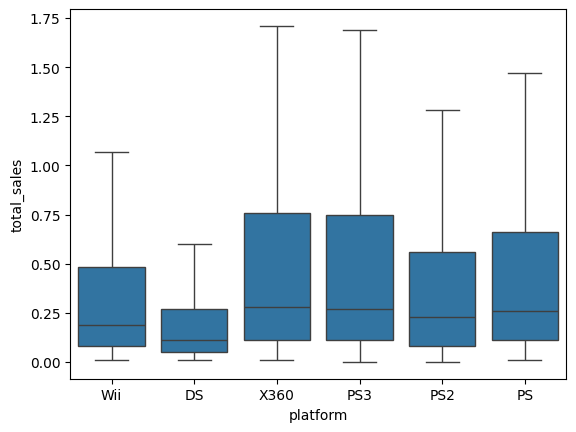

In [279]:
import seaborn as sns
sns.boxplot(top6_sales_df,x='platform',y='total_sales', showfliers=False)

In [272]:
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01
